In [ ]:
from os import listdir as l
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
ann = "/home/aritra/project/quatLT23/data/VOC/VOCdevkit/VOC2012/Annotations"
img = "/home/aritra/project/quatLT23/data/VOC/VOCdevkit/VOC2012/JPEGImages"
yan = "/home/aritra/project/quatLT23/data/VOC/VOCdevkit/VOC2012/yolo_annotations"
# segC = "/home/aritra/project/quatLT23/data/VOC/VOCdevkit/VOC2012/SegmentationClass"
# segO = "/home/aritra/project/quatLT23/data/VOC/VOCdevkit/VOC2012/SegmentationObject"
anns = sorted(l(ann))
imgs = sorted(l(img))
yans = sorted(l(yan))
# segCs = sorted(l(segC))
# segOs = sorted(l(segO))

In [ ]:
# # Checking if names of images and annotations are same except for the extension
# list(map(lambda x: x.replace(".xml", ".jpg"), anns)) == imgs

In [ ]:
plt.imshow(plt.imread(img + "/" + imgs[1]))

In [ ]:
with open(ann + "/" + anns[1]) as f:
    print(f.read())

In [ ]:
with open(yan + "/" + yans[1]) as f:
    print(f.read())

In [ ]:
from json import load
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


class PascalVOCDataset(Dataset):
    def __init__(self, length=17125):

        with open("/home/aritra/project/quatLT23/base_dirs.json") as f:
            base_dir = load(f)["pascal_voc"]

        self.image_dir = base_dir+"/JPEGImages"
        self.annotation_dir = base_dir+"/yolo_annotations"
        self.transform = transforms.Compose([
            transforms.Resize((448, 448)),
            transforms.ToTensor(),
            # transforms.ToTensor() does 3 things:
            #     1. Converts PIL image to numpy ndarray
            #     2. Normalizes the pixel values between 0 and 1. 0: 0, 255: 1
            #     3. Transposes the channel (H x W x C) to (C x H x W)
        ])

        self.image_list = sorted(os.listdir(self.image_dir))
        self.annotation_list = sorted(os.listdir(self.annotation_dir))
        
        print(self.image_list)
        print(self.annotation_list)
        
        print(len(self.image_list))
        print(len(self.annotation_list))
        
        if len(self.image_list) != len(self.annotation_list):
            raise Exception("Number of images and annotations do not match!")

        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        image_path = f"{self.image_dir}/{self.image_list[index]}"
        annotation_path = f"{self.annotation_dir}/{self.annotation_list[index]}"

        image = Image.open(image_path).convert("RGB")

        with open(annotation_path, "r") as f:
            annotation_lines = f.readlines()

        # Parse annotations
        annotations = []
        for line in annotation_lines:
            label, x_center, y_center, width, height = line.strip().split()
            label = int(label)
            x_center, y_center, width, height = map(float, (x_center, y_center, width, height))
            annotations.append((label, x_center, y_center, width, height))

        # Apply transformations
        if self.transform is not None:
            image = self.transform(image)

        return image, annotations

dataset = PascalVOCDataset()

In [ ]:
image, annotations = dataset[1]

In [ ]:
np.array(image)#.shape

In [ ]:
plt.imshow(image.permute(1, 2, 0))

In [ ]:
annotations

In [ ]:
from json import load
import os
import torch
from torch.utils.data import Dataset#, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def convert_annotations(annotations, S=7, C=20):
    # Create empty annotation tensor
    annotation_tensor = torch.zeros((S, S, C + 5))

    for annotation in annotations:
        label, x, y, width, height = annotation

        # Calculate grid cell indices
        cell_row = int(y * S)
        cell_col = int(x * S)
        # print(cell_row, cell_col)

        # Calculate relative coordinates
        rel_x = x * S - cell_col
        rel_y = y * S - cell_row
        rel_w = width * S
        rel_h = height * S

        # Assign class label and bounding box information
        ann1 = torch.zeros(C)
        ann1[label] = 1.0
        ann2 = torch.tensor([rel_x, rel_y, rel_w, rel_h, 1.0])
        annotation_tensor[cell_row, cell_col] = torch.cat((ann1, ann2))

    return annotation_tensor

class PascalVOCDataset(Dataset):
    def __init__(self, length=17125, S=7, C=20):

        with open("/home/aritra/project/quatLT23/base_dirs.json") as f:
            base_dir = load(f)["pascal_voc"]

        self.image_dir = base_dir+"/JPEGImages"
        self.annotation_dir = base_dir+"/yolo_annotations"
        self.transform = transforms.Compose([
            transforms.Resize((448, 448)),
            # transforms.RandomResizedCrop(size=(448, 448), scale=(0.8, 1.2)),
            transforms.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.1, 0.1)),
            transforms.ToTensor(),
            # transforms.ToTensor() does 3 things:
            #     1. Converts PIL image to torch.Tensor
            #     2. Normalizes the pixel values between 0 and 1. 0: 0, 255: 1
            #     3. Transposes the channel (H x W x C) to (C x H x W)
        ])

        self.image_list = sorted(os.listdir(self.image_dir))
        self.annotation_list = sorted(os.listdir(self.annotation_dir))
        
        if len(self.image_list) != len(self.annotation_list):
            raise Exception("Number of images and annotations do not match!")

        self.length = length
        self.S = S
        self.C = C

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        image_path = f"{self.image_dir}/{self.image_list[index]}"
        annotation_path = f"{self.annotation_dir}/{self.annotation_list[index]}"

        image = Image.open(image_path).convert("RGB")

        with open(annotation_path, "r") as f:
            annotation_lines = f.readlines()

        # Parse annotations
        annotations = []
        for line in annotation_lines:
            label, x_center, y_center, width, height = line.strip().split()
            label = int(label)
            x_center, y_center, width, height = map(float, (x_center, y_center, width, height))
            annotations.append((label, x_center, y_center, width, height))

        # Apply transformations
        if self.transform is not None:
            image = self.transform(image)

        return image, convert_annotations(annotations, self.S, self.C)

dataset = PascalVOCDataset()

In [ ]:
image, annotation = dataset[100]
plt.imshow(image.permute(1, 2, 0))
plt.show()

In [ ]:
!cat /home/aritra/project/quatLT23/data/pascal_voc/VOCdevkit/VOC2012/Annotations/2008_000128.xml

In [ ]:
!cat /home/aritra/project/quatLT23/data/pascal_voc/VOCdevkit/VOC2012/yolo_annotations/2008_000128.txt

In [ ]:
plt.imshow(plt.imread("/home/aritra/project/quatLT23/data/pascal_voc/VOCdevkit/VOC2012/JPEGImages/2008_000128.jpg"))

In [1]:
from json import load
import os
import torch
from torch.utils.data import Dataset#, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
# import numpy as np

def convert_annotations(annotations, S=7, C=20):
    # Create empty annotation tensor
    annotation_tensor = torch.zeros((S, S, C + 5))

    for annotation in annotations:
        label, x, y, width, height = annotation

        # Calculate grid cell indices
        cell_row = int(y * S)
        cell_col = int(x * S)
        if cell_row >= S or cell_col >= S:
            print(cell_row, cell_col, x, y)
        # print(cell_row, cell_col)

        # Calculate relative coordinates
        rel_x = x * S - cell_col
        rel_y = y * S - cell_row
        rel_w = width * S
        rel_h = height * S

        # Assign class label and bounding box information
        ann1 = torch.zeros(C)
        ann1[label] = 1.0
        ann2 = torch.tensor([rel_x, rel_y, rel_w, rel_h, 1.0])
        annotation_tensor[cell_row, cell_col] = torch.cat((ann1, ann2))

    return annotation_tensor

class PascalVOC(Dataset):
    def __init__(self, mode, transform=None, length=None, S=7, C=20):

        with open("/home/aritra/project/quatLT23/base_dirs.json") as f: base_dir = load(f)["pascal_voc"]

        self.image_dir = base_dir+"/JPEGImages"
        self.annotation_dir = base_dir+"/yolo_annotations"
        self.transform = transforms.Compose([
            transforms.Resize((448, 448)),
            # transforms.RandomResizedCrop(size=(448, 448), scale=(0.8, 1.2)),
            transforms.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.1, 0.1)),
            transforms.ToTensor(),
            # transforms.ToTensor() does 3 things:
            #     1. Converts PIL image to torch.Tensor
            #     2. Normalizes the pixel values between 0 and 1. 0: 0, 255: 1
            #     3. Transposes the channel (H x W x C) to (C x H x W)
        ]) if transform is None else transform

        # self.image_list = sorted(os.listdir(self.image_dir))
        # self.annotation_list = sorted(os.listdir(self.annotation_dir))
        with open(base_dir+"/split.json") as f:
            d = load(f).get(mode)
            if d is None: raise Exception("Invalid mode!")
            self.image_list = list(map(lambda x: f"{x}.jpg", d))
            self.annotation_list = list(map(lambda x: f"{x}.txt", d))
        if len(self.image_list) != len(self.annotation_list):
            raise Exception("Number of images and annotations do not match!")

        self.length = len(self.image_list) if length is None else length
        self.S = S
        self.C = C

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        print(self.image_list[index])
        image_path = f"{self.image_dir}/{self.image_list[index]}"
        annotation_path = f"{self.annotation_dir}/{self.annotation_list[index]}"

        image = Image.open(image_path).convert("RGB")

        with open(annotation_path, "r") as f:
            annotation_lines = f.readlines()

        # Parse annotations
        annotations = []
        for line in annotation_lines:
            label, x_center, y_center, width, height = line.strip().split()
            label = int(label)
            x_center, y_center, width, height = map(float, (x_center, y_center, width, height))
            annotations.append((label, x_center, y_center, width, height))

        # Apply transformations
        if self.transform is not None:
            image = self.transform(image)

        return image, convert_annotations(annotations, self.S, self.C)

dataset = PascalVOC("train")

2008_000128.jpg


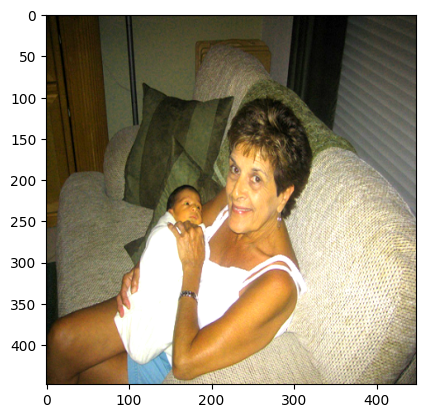

In [2]:
image, annotation = dataset[97]
plt.imshow(image.permute(1, 2, 0))
plt.show()

In [1]:
import torch

def convert_yolo_output_to_target(yolo_output):
    batch_size, grid_size, _, num_predictions = (256, 7, 7, 30)
    num_classes = num_predictions - 2 * 5

    target = torch.zeros(batch_size, grid_size, grid_size, 25)

    for b in range(batch_size):
        for i in range(grid_size):
            for j in range(grid_size):
                offset = num_classes + 5

                # Extract class confidence from the YOLO output
                target[b, i, j, 20] = yolo_output[b, i, j, 20]

                # Extract the bounding box information from the YOLO output
                for k in range(2):
                    target[b, i, j, k*5:(k+1)*5] = yolo_output[b, i, j, num_classes+offset*k:num_classes+offset*(k+1)]

    return target

In [71]:
def convert_cellboxes(predictions, S=7):
    """Converts bounding box predictions into cell indices and offsets.

    Args:
        predictions (array): predictions from the yolo model of shape (batch_size, 7, 7, 30)
        S (int, optional): grid size. Defaults to 7.

    Returns:
        array: cell indices and offsets of shape (batch_size, 7, 7, 6)
                here 6 = [class, confidence, x, y, w, h]
    """
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box_index = scores.argmax(0).unsqueeze(-1)
    best_box = bboxes1 * (1 - best_box_index) + bboxes2 * best_box_index
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_box[..., 0:1] + cell_indices)
    y = 1 / S * (best_box[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_box[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(-1)
    return torch.cat((predicted_class, best_confidence, converted_bboxes), dim=-1)

def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def cellboxes_to_boxes_2(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    return converted_pred

In [67]:
bb1 = torch.rand(256, 7, 7, 30)

In [72]:
# cellboxes_to_boxes(bb1) == cellboxes_to_boxes_2(bb1)
cellboxes_to_boxes_2(bb1).shape

torch.Size([256, 49, 6])